In [51]:
import numpy as np
import pandas as pd
import glob
import os
import geopandas as gpd
import geoplot
import matplotlib.pyplot as plt

# Subway Data

In [52]:
subway = pd.read_csv('MTA_Subway_Stations.csv', sep=",")
display(subway)

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,637,408,619,IRT,Lexington Av,Bleecker St,M,True,6,Subway,40.725915,-73.994659,Uptown,Downtown,1,1,1,NaN,POINT (-73.994659 40.725915)
1,B23,70,70,BMT,West End,Bay 50 St,Bk,False,D,Elevated,40.588841,-73.983765,Manhattan,Coney Island,0,0,0,NaN,POINT (-73.983765 40.588841)
2,607,365,365,IRT,Pelham,Castle Hill Av,Bx,False,6,Elevated,40.834255,-73.851222,Pelham Bay,Manhattan,0,0,0,NaN,POINT (-73.851222 40.834255)
3,S01,139,627,BMT,Franklin Shuttle,Franklin Av,Bk,False,S,Elevated,40.680596,-73.955827,Last Stop,Prospect Park,1,1,1,NaN,POINT (-73.955827 40.680596)
4,M18,102,625,BMT,Jamaica,Delancey St-Essex St,M,True,M J Z,Subway,40.718315,-73.987437,Brooklyn,Inbound,0,0,0,NaN,POINT (-73.987437 40.718315)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,B06,222,222,IND,63rd St,Roosevelt Island,M,False,F,Subway,40.759145,-73.953260,Queens,Downtown,1,1,1,NaN,POINT (-73.95326 40.759145)
492,710,454,616,IRT,Flushing,74 St-Broadway,Q,False,7,Elevated,40.746848,-73.891394,Outbound,Manhattan,1,1,1,NaN,POINT (-73.891394 40.746848)
493,606,364,364,IRT,Pelham,Zerega Av,Bx,False,6,Elevated,40.836488,-73.847036,Pelham Bay,Manhattan,0,0,0,NaN,POINT (-73.847036 40.836488)
494,F14,232,232,IND,6th Av - Culver,2 Av,M,True,F,Subway,40.723402,-73.989938,Uptown,Downtown,0,0,0,NaN,POINT (-73.989938 40.723402)


## Drop unnecessary Columns

In [53]:
subway = subway.drop(columns=['GTFS Stop ID', 'Complex ID', 'Station ID', 'Daytime Routes', 'Structure', 'North Direction Label', 
                              'South Direction Label', 'ADA Northbound', 'ADA Southbound', 'ADA Notes', 'Georeference'])
subway['ADA'] = subway['ADA'].astype(bool)
subway = subway.rename(columns={'GTFS Latitude': 'Latitude', 'GTFS Longitude': 'Longitude'})
subway.dtypes

Division      object
Line          object
Stop Name     object
Borough       object
CBD             bool
Latitude     float64
Longitude    float64
ADA             bool
dtype: object

# Exploratory Analysis

## Missing values

In [54]:
na_count = subway.isna().sum(axis=0)
print(na_count)

Division     0
Line         0
Stop Name    0
Borough      0
CBD          0
Latitude     0
Longitude    0
ADA          0
dtype: int64


## Validate columns

In [55]:
object_columns = subway.select_dtypes(include='object').columns

for col in object_columns:
    unique_values = subway[col].unique()
    print(f"Column: {col}")
    print(f"Unique Values ({len(unique_values)}): {unique_values}")
    print("-" * 50)

Column: Division
Unique Values (4): ['IRT' 'BMT' 'SIR' 'IND']
--------------------------------------------------
Column: Line
Unique Values (34): ['Lexington Av' 'West End' 'Pelham' 'Franklin Shuttle' 'Jamaica'
 'Staten Island' 'Eastern Pky' 'Clark St' '6th Av - Culver' 'Flushing'
 'Astoria' '8th Av - Fulton St' 'Canarsie' 'Concourse' 'Queens Blvd'
 'Broadway - 7Av' 'Jerome Av' 'Lenox - White Plains Rd' 'Rockaway'
 'Broadway - Brighton' 'Second Av' 'Broadway' 'Crosstown' '4th Av'
 'Myrtle Av' 'Nostrand' 'Liberty Av'
 'Sea Beach / West End / Culver / Brighton' 'Sea Beach' 'Dyre Av'
 'Queens - Archer' '63rd St' 'Manhattan Bridge' 'Lexington - Shuttle']
--------------------------------------------------
Column: Stop Name
Unique Values (378): ['Bleecker St' 'Bay 50 St' 'Castle Hill Av' 'Franklin Av'
 'Delancey St-Essex St' 'Grasmere' 'Saratoga Av' 'Wall St' 'Avenue P'
 'Times Sq-42 St' 'East Broadway' 'Astoria-Ditmars Blvd' 'Cleveland St'
 'Dongan Hills' 'New Lots Av' 'Chambers St' '6 Av' 

In [57]:
print(f"Latitude min: {subway['Latitude'].min()}")
print(f"Latitude max: {subway['Latitude'].max()}")
print(f"Longitude min: {subway['Longitude'].min()}")
print(f"Longitude max: {subway['Longitude'].max()}")

Latitude min: 40.512764
Latitude max: 40.903125
Longitude min: -74.251961
Longitude max: -73.755405


## Visual analysis

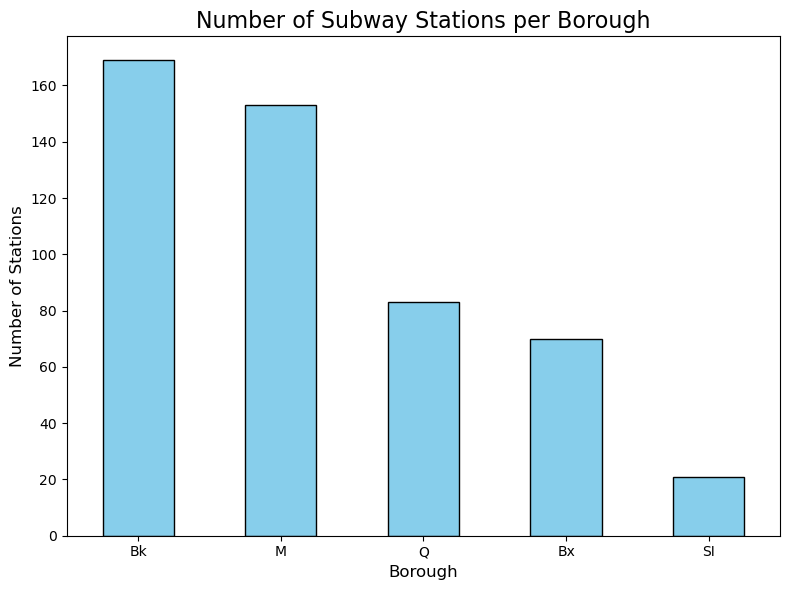

In [58]:
borough_counts = subway['Borough'].value_counts()

plt.figure(figsize=(8, 6))
borough_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Subway Stations per Borough', fontsize=16)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


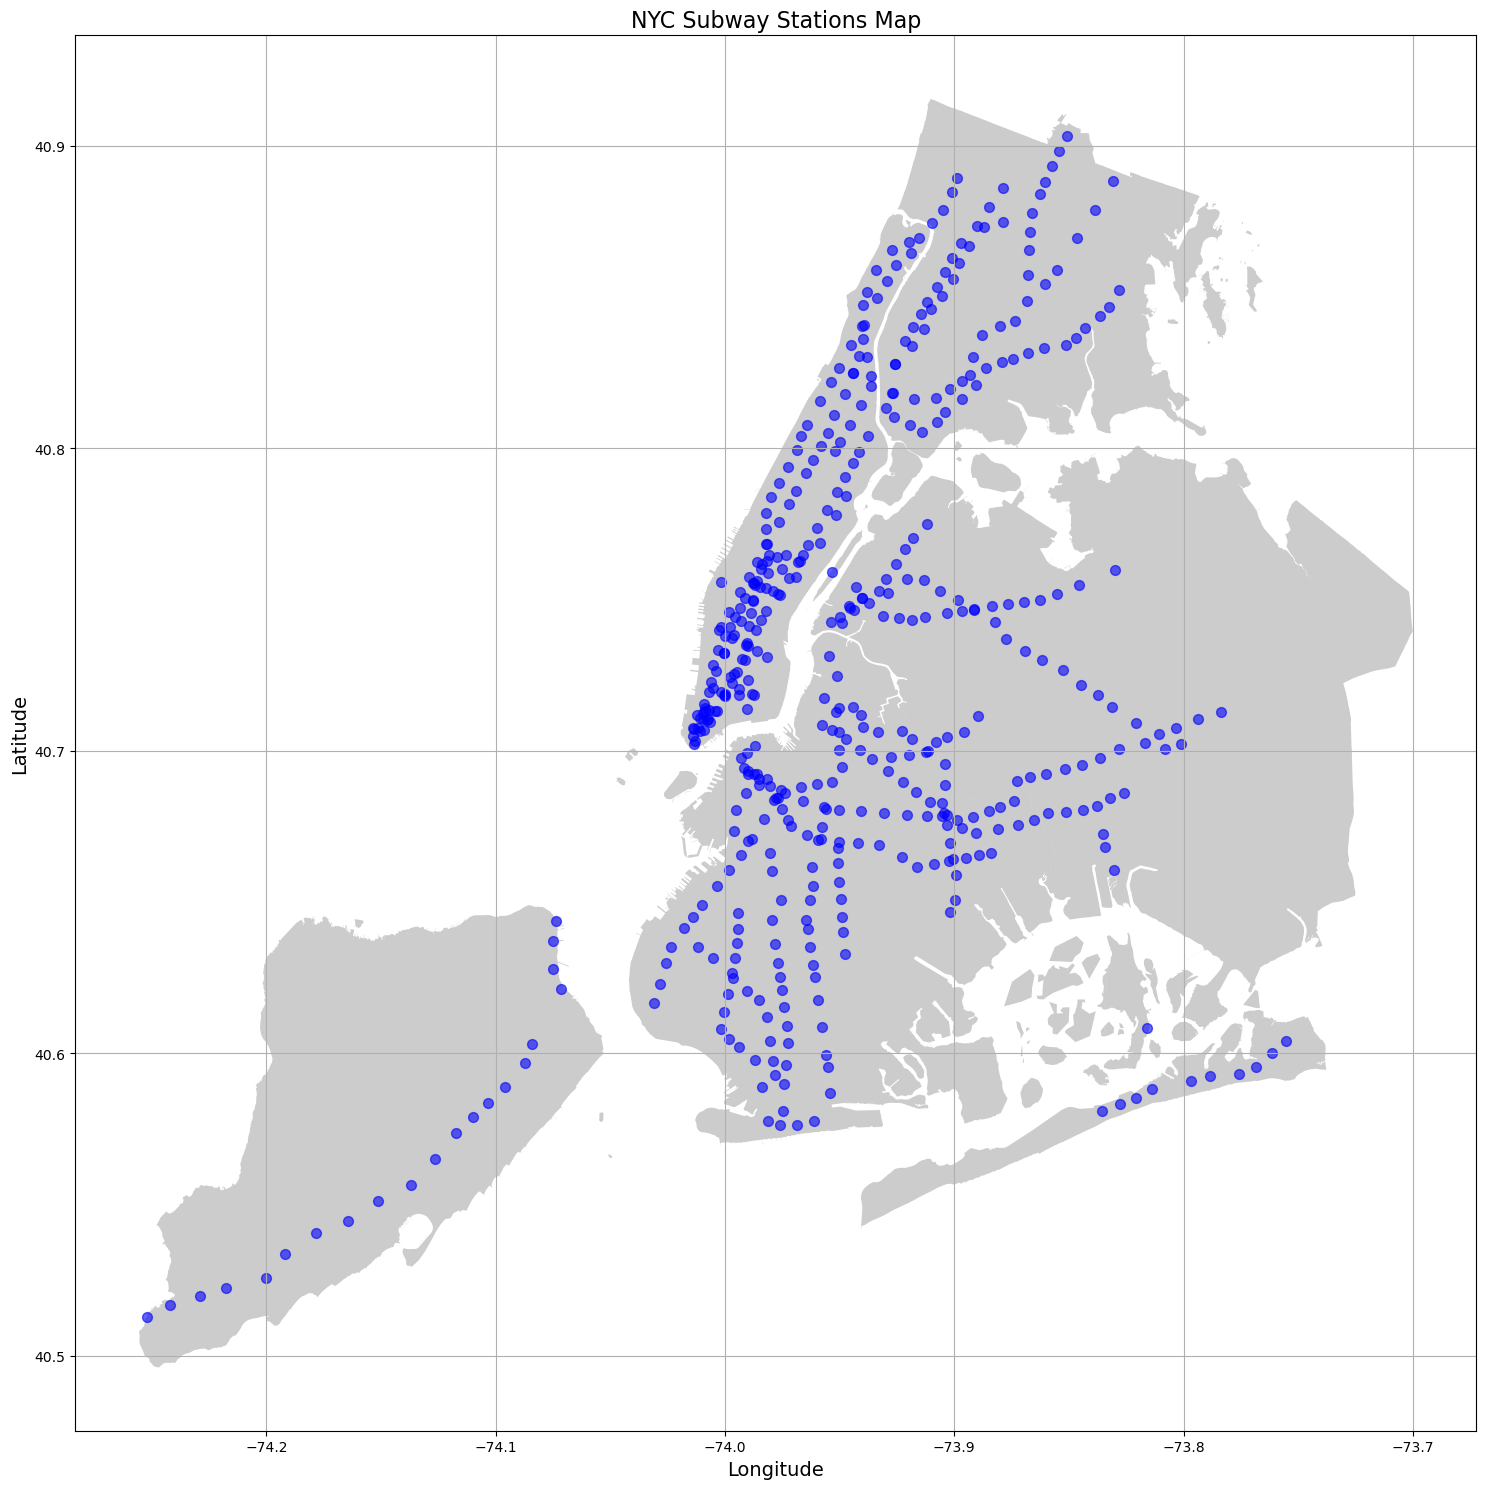

In [60]:
boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))

crs={'init':'epsg:4326'} 

geometry = gpd.points_from_xy(subway["Longitude"], subway["Latitude"])
geo_df = gpd.GeoDataFrame(subway, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15, 15))
boroughs.plot(ax=ax, alpha=0.4, color="grey")

#geo_df[geo_df['CBD'] == True].plot(ax=ax, markersize=200, alpha=0.4, color="green", label="Part of CBD")
#geo_df[geo_df['CBD'] == False].plot(ax=ax, markersize=200, alpha=0.4, color="red", label="Not Part of CBD")
geo_df.plot(ax=ax, markersize=50, alpha=0.6, color="blue", label="Subway Station")

plt.title("NYC Subway Stations Map", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Encoding categorical Data

In [61]:
subway = pd.get_dummies(subway, columns=['Division', 'Line', 'Borough'], drop_first=True)

In [62]:
display(subway)

,Stop Name,CBD,Latitude,Longitude,ADA,Division_IND,Division_IRT,Division_SIR,Line_63rd St,Line_6th Av - Culver,...,Line_Rockaway,Line_Sea Beach,Line_Sea Beach / West End / Culver / Brighton,Line_Second Av,Line_Staten Island,Line_West End,Borough_Bx,Borough_M,Borough_Q,Borough_SI
0,Bleecker St,True,40.725915,-73.994659,True,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,Bay 50 St,False,40.588841,-73.983765,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,Castle Hill Av,False,40.834255,-73.851222,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,Franklin Av,False,40.680596,-73.955827,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Delancey St-Essex St,True,40.718315,-73.987437,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Roosevelt Island,False,40.759145,-73.953260,True,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
492,74 St-Broadway,False,40.746848,-73.891394,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
493,Zerega Av,False,40.836488,-73.847036,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
494,2 Av,True,40.723402,-73.989938,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


### DONE!

# Bus Dataset

In [63]:
bus = pd.read_csv('Bus_Stop_Shelter.csv', sep=",")
display(bus)

,the_geom,BoroCode,BoroName,BoroCD,CounDist,AssemDist,StSenDist,CongDist,Shelter_ID,Corner,On_Street,Cross_Stre,Longitude,Latitude,NTAName,FEMAFldz,FEMAFldT,HrcEvac
0,POINT (-73.94874357365637 40.64085475597672),3,Brooklyn,317,45,42,21,9,BR02218,SW,AV D,NOSTRAND AV,-73.948745,40.640863,East Flatbush-Erasmus,X,AREA OF MINIMAL FLOOD HAZARD,5.0
1,POINT (-74.02283555116742 40.6292447605423),3,Brooklyn,310,43,46,26,11,BR02219,SW,5 AV,BAY RIDGE PKWY,-74.022837,40.629253,Bay Ridge,X,AREA OF MINIMAL FLOOD HAZARD,NaN
2,POINT (-73.92467258003798 40.67375874807616),3,Brooklyn,308,41,55,20,9,BR02220,SE,ST MARKS AV,BUFFALO AV,-73.924674,40.673767,Crown Heights (North),X,AREA OF MINIMAL FLOOD HAZARD,NaN
3,POINT (-73.9401345806071 40.578033768126936),3,Brooklyn,315,48,45,23,8,BR02221,SW,ORIENTAL BLVD,MACKENZIE ST,-73.940136,40.578042,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,X,AREA OF MINIMAL FLOOD HAZARD,1.0
4,POINT (-73.93991658060635 40.57805676808165),3,Brooklyn,315,48,45,23,8,BR02222,SW,ORIENTAL BLVD,MACKENZIE ST,-73.939918,40.578065,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,X,AREA OF MINIMAL FLOOD HAZARD,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,POINT (-74.11221352595592 40.5678197761412),5,Staten Island,502,50,64,24,11,SI05219,NE,Hylan Blvd,Beach Av,-74.112215,40.567828,New Dorp-Midland Beach,X,AREA OF MINIMAL FLOOD HAZARD,4.0
3326,POINT (-74.16856250790204 40.57400177692753),5,Staten Island,502,51,63,24,11,SI05220,NW,Independence Av,Pathmark,-74.168564,40.574010,New Springville-Willowbrook-Bulls Head-Travis,X,AREA OF MINIMAL FLOOD HAZARD,3.0
3327,POINT (-74.09298952767594 40.64534875958313),5,Staten Island,501,49,61,23,11,SI05221,SW,Richmond Terrace,Franklin Av,-74.092991,40.645357,St. George-New Brighton,X,AREA OF MINIMAL FLOOD HAZARD,NaN
3328,POINT (-74.12038852436673 40.56029177738492),5,Staten Island,503,50,64,24,11,SI05222,SW,HYLAN BLVD,GUYON AV,-74.120390,40.560300,Oakwood-Richmondtown,X,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,2.0


## Drop unnecessary Columns + ensure consistency with subway data

In [67]:
columns_to_keep = ['BoroName', 'Longitude', 'Latitude']
bus = bus[columns_to_keep]
bus = bus.rename(columns={'BoroName': 'Borough'})
bus.dtypes

Borough       object
Longitude    float64
Latitude     float64
dtype: object

In [68]:
borough_mapping = {
    'Brooklyn': 'Bk',
    'Queens': 'Q',
    'Bronx': 'Bx',
    'Manhattan': 'M',
    'Staten Island': 'SI'
}

bus['Borough'] = bus['Borough'].replace(borough_mapping)

# Exploratory Analysis

## Missing values

In [69]:
na_count = bus.isna().sum(axis=0)
print(na_count)

Borough      0
Longitude    0
Latitude     0
dtype: int64


## Validate columns

In [70]:
object_columns = bus.select_dtypes(include='object').columns

# Loop through these columns and print their unique values
for col in object_columns:
    unique_values = bus[col].unique()
    print(f"Column: {col}")
    print(f"Unique Values ({len(unique_values)}): {unique_values}")
    print("-" * 50)

Column: Borough
Unique Values (5): ['Bk' 'Q' 'Bx' 'M' 'SI']
--------------------------------------------------


In [71]:
print(f"Latitude min: {bus['Latitude'].min()}")
print(f"Latitude max: {bus['Latitude'].max()}")
print(f"Longitude min: {bus['Longitude'].min()}")
print(f"Longitude max: {bus['Longitude'].max()}")

Latitude min: 40.506049
Latitude max: 40.912781
Longitude min: -74.239183
Longitude max: -73.712455


## Visual Analyis

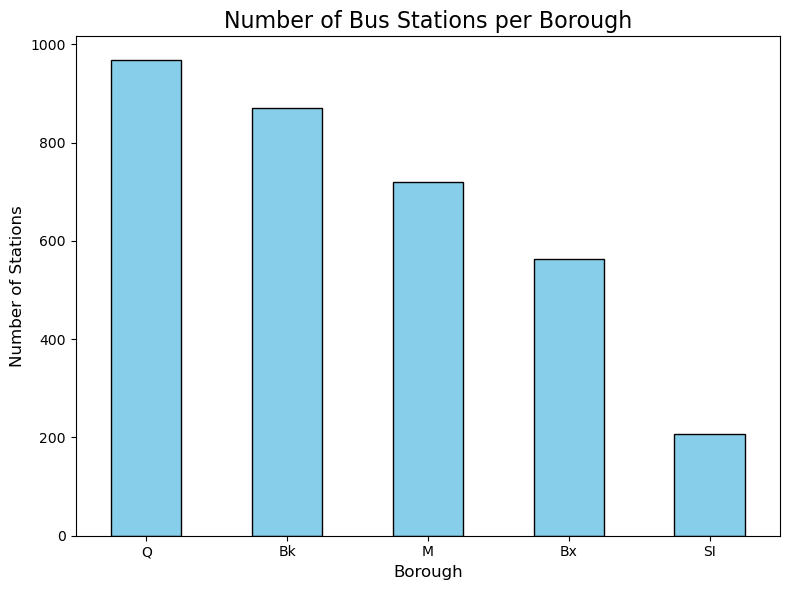

In [73]:
borough_counts = bus['Borough'].value_counts()

plt.figure(figsize=(8, 6))
borough_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Bus Stations per Borough', fontsize=16)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


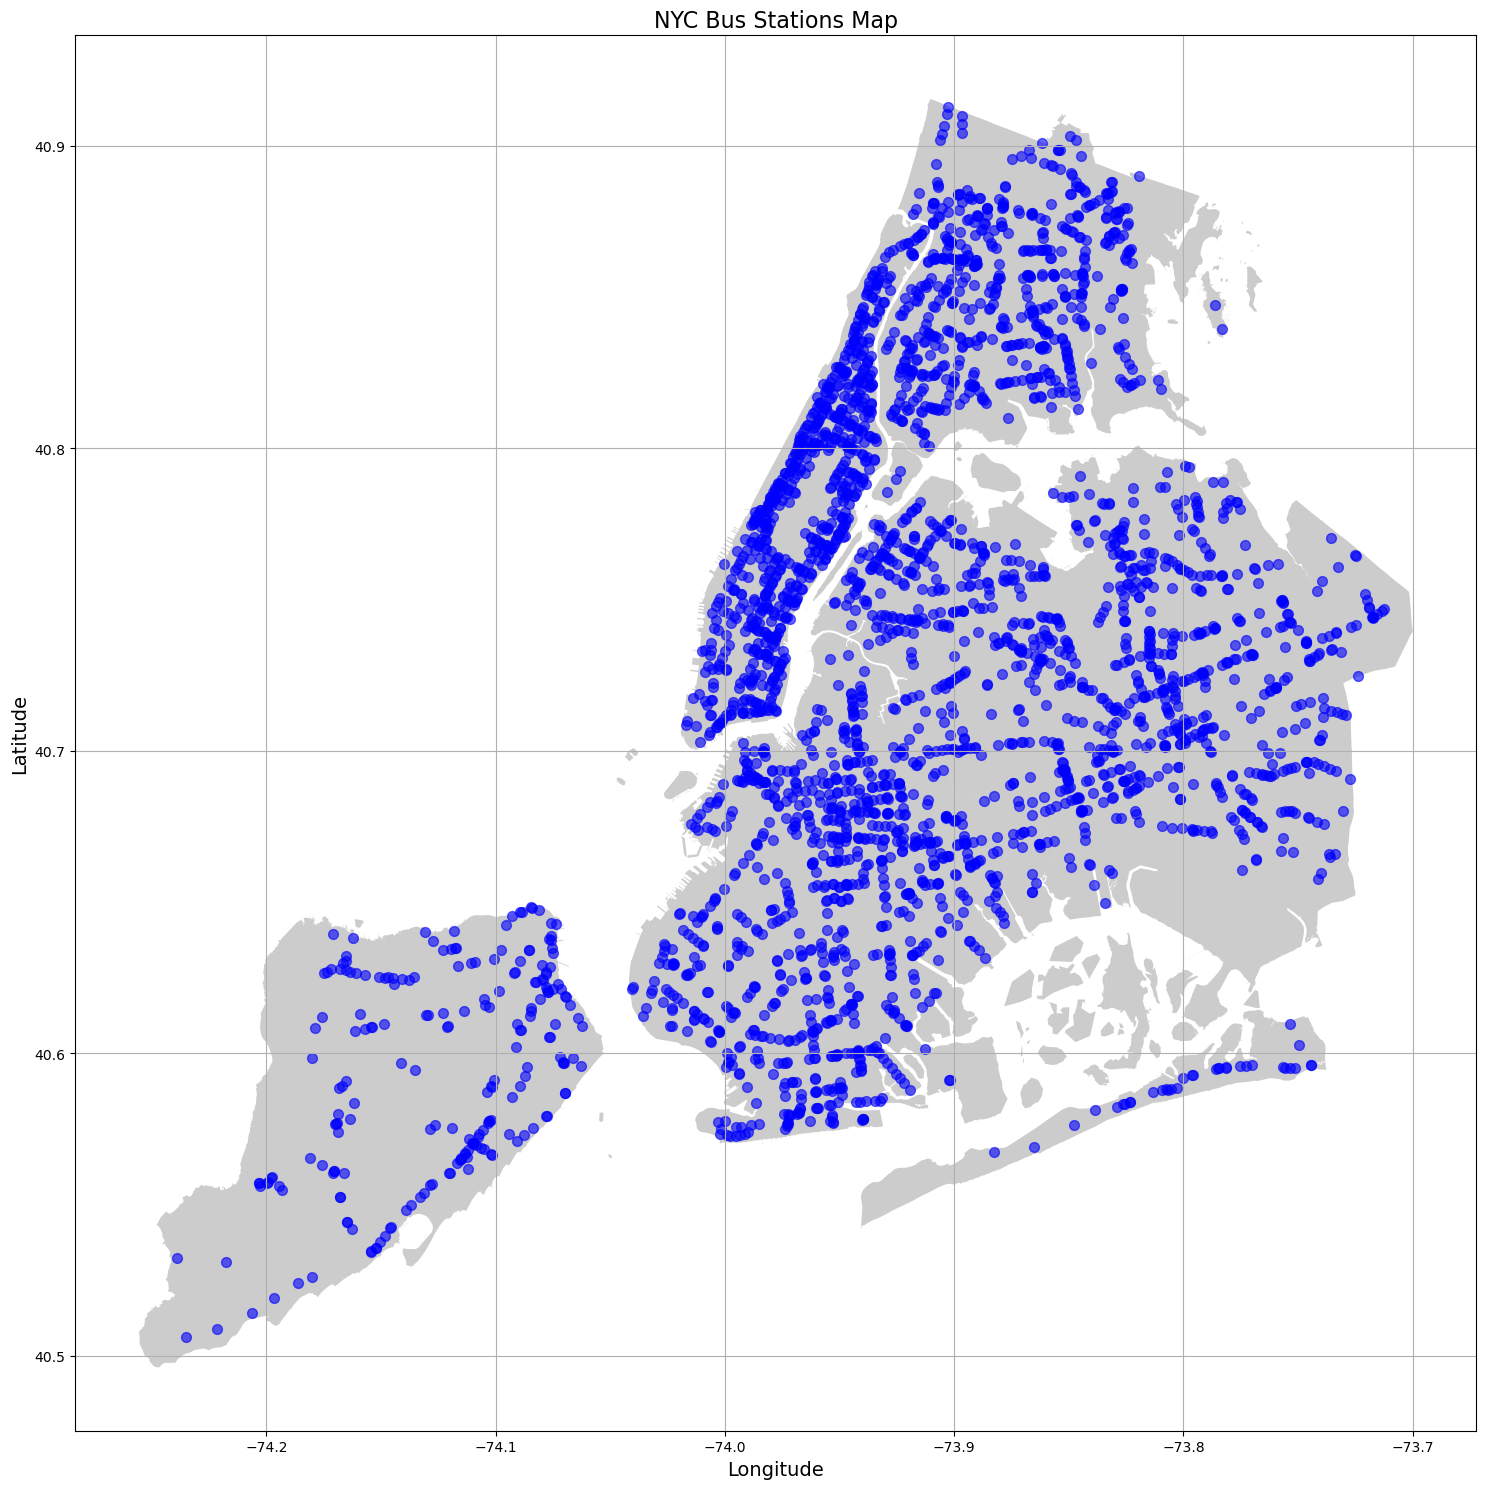

In [74]:
boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))

crs={'init':'epsg:4326'} 

geometry = gpd.points_from_xy(bus["Longitude"], bus["Latitude"])
geo_df = gpd.GeoDataFrame(bus, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15, 15))
boroughs.plot(ax=ax, alpha=0.4, color="grey")

#geo_df[geo_df['CBD'] == True].plot(ax=ax, markersize=200, alpha=0.4, color="green", label="Part of CBD")
#geo_df[geo_df['CBD'] == False].plot(ax=ax, markersize=200, alpha=0.4, color="red", label="Not Part of CBD")
geo_df.plot(ax=ax, markersize=50, alpha=0.6, color="blue", label="Subway Station")

plt.title("NYC Bus Stations Map", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Encoding categorical Data

In [76]:
bus = pd.get_dummies(bus, columns=['Borough'], drop_first=True)
display(bus)

,Longitude,Latitude,Borough_Bx,Borough_M,Borough_Q,Borough_SI
0,-73.948745,40.640863,False,False,False,False
1,-74.022837,40.629253,False,False,False,False
2,-73.924674,40.673767,False,False,False,False
3,-73.940136,40.578042,False,False,False,False
4,-73.939918,40.578065,False,False,False,False
...,...,...,...,...,...,...
3325,-74.112215,40.567828,False,False,False,True
3326,-74.168564,40.574010,False,False,False,True
3327,-74.092991,40.645357,False,False,False,True
3328,-74.120390,40.560300,False,False,False,True


### DONE!

In [79]:
# Save files
subway.to_csv('../data/transport/subway_processed.csv')
bus.to_csv('../data/transport/bus_processed.csv')